# 4.5 权重衰减

## 4.5.1 范数与权重衰减

在训练参数化机器学习模型时，权重衰减（通常称为L2正则化）是最广泛使用的正则化的技术之一。

平衡这个新的额外惩罚的损失：通过正则化常数λ来描述这种权衡，这是一个非负超参数

L2正则化线性模型构成经典的岭回归（ridge regression）算法

L1正则化线性回归是统计学中类似的基本模型，通常被称为套索回归（lasso regression）。

L2范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。

L1惩罚会导致模型将其他权重清除为零而将权重集中在一小部分特征上。这称为特征选择（feature selection），这可能是其他场景下需要的。

## 4.5.2 高维线性回归

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 将问题的维数增加到d=200，并使用一个只包含20个样本的小训练集。
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5

# true_w [200,1],每个值都是0.01
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

# 见3.2：synthetic_data:"""Generate y = Xw + b + noise."""
train_data = d2l.synthetic_data(true_w, true_b, n_train)
# train_data[0].shape[20,200],
# train_data[1].shape[20,1]

# 见3.3：load_array:"""Construct a PyTorch data iterator."""
train_iter = d2l.load_array(train_data, batch_size)

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 4.5.3 初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 4.5.4 定义L2范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

## 4.5.5 定义训练代码实现

def linreg(X, w, b):
    """The linear regression model."""
    return d2l.matmul(X, w) + b

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

## 4.5.7 忽略正则化直接训练

w的L2范数是： 12.971717834472656


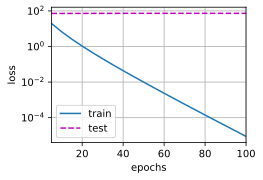

In [6]:
train(lambd=0)

## 4.5.8 使用权重衰减

w的L2范数是： 0.3510304093360901


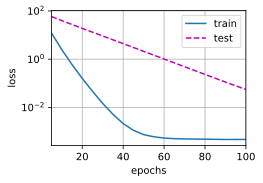

In [7]:
train(lambd=3)

## 4.5.9 简洁实现

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())


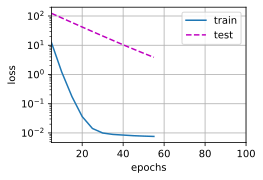

In [ ]:
train_concise(0),train_concise(3)

## 4.5.10 小结
* 正则化是处理过拟合的常用方法。在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同一训练代码实现中，不同的参数集可以有不同的更新行为。

## 4.5.11 练习

1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试准确率关于$\lambda$的函数。你观察到了什么？
1. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？
1. 如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。你能找到类似的矩阵方程吗（见 :numref:`subsec_lin-algebra-norms` 中的弗罗贝尼乌斯范数）？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，你还能想出其他什么方法来处理过拟合？
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x)